# FEI of trimesh mechanics
Tim Tyree<br>
6.17.2020

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
sys.path.append("../lib") 
from lib import *
sys.path.append("lib") 
from lib import *
from operari import *
from ProgressBar import *
# from mesh_ops import *

# the visualization tools involved here for triangular meshes is
import trimesh
import pyglet
from numba import njit, cuda
# from numba.typed import List
# import numba
import trimesh

#try using a scipy sparse matrix to speed up spring force evaluations
#TODO: speed up bigger meshes with pycuda's sparce matrices
from scipy.sparse import csr_matrix
import scipy.sparse as sparse

# from pyspark import SparkContext 
# sc = SparkContext(master="local[4]")
# print(sc)


%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


#  import mesh of right atrium

In [129]:
vert = np.loadtxt('Data/pt85_RA_vert')
faces = np.loadtxt('Data/pt85_RA_faces')
faces = faces - 1 #fix: 1 to 0 indexing
mesh = trimesh.Trimesh(vertices=vert, faces=faces)
mesh.vertices /= 10 #convert length units from mm to cm
vertices = mesh.vertices.view(np.ndarray)

In [323]:
assert(os.path.exists('Data/patient85_RA_closed.stl'))
mesh = trimesh.load('Data/patient85_RA_closed.stl')
mesh.vertices /= 10 #convert length units from mm to cm

A typicall RA has a long axis <45mm.  here we have 53mm, and we can infer the length units are in mm. Thus the surface area of this raw RA mesh is reasonably $46\,cm^2$ and the raw units were given in millimeters, which I rescale to cm.

# reasoning for parameters

## mass of the right atrium
A reasonable value for the density of myocardial tissue has been reported [here](https://bionumbers.hms.harvard.edu/files/Density%20and%20mass%20of%20each%20organ-tissue.pdf) to be $1.050\,g/cm^3$.  A reasonable value for the thickness of the atrial wall can be taken to be $1\,mm$, though in some pathological cases of atrial hypertrophy this thickness may vary somewhat.  Supposing this, we then assume a constant mass area density with the reasonable value of $\mu=(1.05*0.1)=0.105\approx0.1\,g/cm^2$.

The initial surface area of this raw atrial mesh computed to be $A_\text{total} = 46.003\,cm^2$, which is rather large compared to the typical right atrium surface areas of $15-30cm^2$ reported [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3627628).  This suggests a total mass of $M_\text{total} = 4.8$ grams.  Typical masses of the whole human heart tend to be in the range $300-350$ grams, so this right atrium, which is likely dilated to prompt its measure, is estimated to compose roughly $1.4-1.6$% of the mass of their entire heart.

We initialize the mass of the $i^\text{th}$ vertex according to $m_i = \frac{\mu}{3}\sum_{j=1}^{n_i}|\vec{A}_j|$, which may hold fixed because barycentric coordinates are homogeneous.


In [51]:
print(f"the mass of this patient's RA is roughly {100*((mesh.area*.105)/350):.1f}-{100*((mesh.area*.105)/300):.1f}% of the mass of their whole heart.")


the mass of this patient's RA is roughly 1.4-1.6% of the mass of their whole heart.


In [751]:
def get_mass(vid, mesh):
    mu = 0.105 #g/cm^2 
    #assume locations are in units of cm
    star = mesh.vertex_faces[vid]
    star = star[star>-1]
    mass = mu/3*np.add.reduce(mesh.area_faces[star])
    return mass #vertex mass in grams

In [248]:
mass = [get_mass(vid, mesh) for vid in range(mesh.vertices.shape[0])]

In [75]:
np.add.reduce(M)

4.830362501009423

## Wall stress in the RA
Wall stress varies widely within atria and between subjects, but a median value is median, $\sigma = 36$ kPa (IQR = $26–51$ kPa), as reported [here](https://www.ahajournals.org/doi/full/10.1161/circep.111.965541).  This suggests a reasonable initial wall stress is $\gamma = \sigma\times\text{thickness} = 36*133*10^{-2} N/cm = 4.8*10^6 dyn/cm =   4788000 \; (gcm/s^2)\, /\, cm$. 

:fearful: That's pretty big.  Yep.  That's what a typical surface tension aught be in a human right atrium (RA).

In [83]:
gamma = 36*133*10**(-2+5) #( g cm / s^2 ) / cm

## assuming constant wall stress, assign a spring constant and equilibrium length to each edge

We have some force per unit length we can define as
$$
\gamma = \frac{k\Delta x}{x_0 + \Delta x}
$$
Initially, we have $x_\text{initial} = x_0 + \Delta x_\text{initial}$, so for each vertex, we can compute the lengths where the springs exert zero force to be

$$x_0 = (1 - \gamma/k)x_\text{initial}$$

We expect to initialize with a stretched membrane. Hence, we expect $0<x_0<x_\text{initial}$. We require that at each vertex $x_0$ to be chosen in a way consistent with the nonzero volume, $V_0>0$, that is present in the RA when the pressure difference accross the atrial wall is $P=0$.

We further require at each vertex the spring constants $k$ to be chosen in a way consistent with experimentally observed values of atrial contractility, $\mathscr{E}=\partial P / \partial V_\text{total}$, which is a global observable in this model.  This decision is a nontrivial one-to-many mapping that relates two global observables, pressure and volume, to local vertex rules tissue contraction.  There exist many models of contractility of the human heart, some of which model contractility of striated cardiac muscle fibrilles in terms of a slow inward electric current that is often attributed to $Ca^{2+}$ released from the sarcoplasmic reticulum of the cardiomyocyte.  

Handling one problem at a time, we will consider first a simplified model that produces constant contractility.

for  to  must take place before the human atrium can ta

In [74]:
#using my Astar method
P = 1. #the pressure difference between the inside and the outside of the mesh
pressure_forces = np.array([get_A(vid, mesh) for vid in range(mesh.vertices.shape[0])])
pressure_forces *= P
pressure_forces[0]

array([0.00462784, 0.00106466, 0.00458089])

In [19]:
# this takes 2.8 seconds to compute the net forces on 806 rows.  Not ideal
net_spring_forces = 0.*vertices
for rowid, row in df.iterrows():
    b, a, k, x0 = row[['b','a','k','x0']]
    b = int(b); a = int(a)
    F = spring_force(x=vertices[b] - vertices[a],x0=x0,k=k)
    net_spring_forces[a] += F
    net_spring_forces[b] -= F

NameError: name 'df' is not defined

## Mechanical equilibrium yields predictions of elastance and filling pressure in the right atrium

Local equilibrium with constant surface tension suggests from Newton's second law that
$$
0 \overset{!}{=} m_i\ddot{\vec{q}} = P\vec{A}_\star(\vec{q}_i) + \sum_{j=1}^{n_i}\gamma (\vec{q}_j-\vec{q}_i).
$$

\begin{eqnarray*}
V_\text{total} &=& \frac{1}{3}\sum_{i=1}^{N_\text{vertices}}V_\star(\vec{q}_i) \\
&=& \frac{1}{3}\sum_{i=1}^{N_\text{vertices}}\vec{A}_\star(\vec{q}_i)\cdot (\vec{q}_i-\vec{q}_0) \\
&=& \frac{1}{3}\sum_{i=1}^{N_\text{vertices}} \frac{-\gamma}{P}\Big(\sum_{j=1}^{n_i}(\vec{q}_j-\vec{q}_i)\Big)   \cdot (\vec{q}_i-\vec{q}_0) \\
&=& \frac{-\gamma}{3P}\sum_{i=1}^{N_\text{vertices}}(\vec{q}_i-\vec{q}_0)\cdot\bigg(\Big( \sum_{j=1}^{n_i}\vec{q}_j   \Big)-n_i\vec{q}_i\bigg)
\end{eqnarray*}

Realizing that $Q\equiv(\vec{q}_i-\vec{q}_0)\cdot\bigg(\Big( \sum_{j=1}^{n_i}\vec{q}_j   \Big)-n_i\vec{q}_i\bigg)$ is a purely geometrical scalar quantity, we arrive at the relatively simple equation of state,

$$
3PV_\text{total} = -\gamma Q
$$

Differentiating supplies us with the elastance of our model for an elastic membrane/closed unstructured triangular mesh.

$$
\mathscr{E}\equiv\frac{\partial P}{\partial V} = \frac{\gamma Q}{3V_\text{total}^2} = \frac{3P^2}{\gamma Q}
$$



## computation of Q, initially

Q is indeed independent of choice of $\vec{q}_0$.  Its numerical value is $Q=-180cm^2$.  This predicts an RA pressure of 8,000 mmHg, which is much more than the physiological 5-10 mmHg.  Either

* Q is funny because the system is not at equilibrium
* The assumption that constant wall stress is bad

TODO: What if I redo the MFT argument without assuming constant wall stress, but instead just assuming constant spring coefficients, $k$?

## even for the closed mesh, Q is not at equilibrium.  


In [131]:
# def get_Q_star(vid, mesh, q0=(0,0,0)):
#     q  = mesh.vertices[vid]
#     N1q = np.array(mesh.vertex_neighbors[vid])
#     N1q = N1q[N1q>-1]
#     d_star = np.add.reduce([qj-q for qj in mesh.vertices[N1q]])
#     Q_star = np.dot(q-q0, d_star)
#     return float(Q_star)

In [132]:
# def get_Q(mesh, q0=(0,0,0)):
#     return np.add.reduce([get_Q_star(vid=vid, mesh=mesh, q0=q0) for vid in range(mesh.vertices.shape[0])])

In [178]:
get_Q(mesh, q0=(1,-30,1))

-285.0738193826926

In [140]:
# P = 
-gamma*get_Q(mesh)/(3*26) #vtotal is about 26cm^3 here

17499146.7590299

In [141]:
(180*36*1.33/(3*26)*10**4)/133

8307.692307692309

In [142]:
47.88*10**4/133

3600.0

In [143]:
225/3600

0.0625

## some function definitions

In [305]:
# @njit
# def flow_map(q,p,net_force, mass):
#     dqdt = p/mass
#     dpdt = net_force
#     return dqdt, dpdt

In [341]:
# #using my Astar method
# P = 5. #mmhg the pressure difference between the inside and the outside of the mesh
# P = P * 1333 #dyn/cm^2, dyn = g cm / s^2
# def get_Fp(mesh, P):
#     pressure_forces = np.array([get_A(vid, mesh) for vid in range(mesh.vertices.shape[0])])
#     pressure_forces *= P
#     return pressure_forces


In [342]:
# # this takes 2.8 seconds to compute the net forces on 806 rows.  Not ideal
# def get_Fs(mesh, df):
#     net_spring_forces = 0.*mesh.vertices
#     for rowid, row in df.iterrows():
#         b, a, k, x0 = row[['b','a','k','x0']]
#         b = int(b); a = int(a)
#         F = spring_force(x=mesh.vertices[b] - mesh.vertices[a],x0=x0,k=k)
#         net_spring_forces[a] -= F
#         net_spring_forces[b] += F
#     return net_spring_forces

# a plain and simple forward euler integration

Okay spring force calculation is impractically slow on this device without cuda.  just use numba.cuda on my ultrabook overnight :)

In [337]:
#make a df to hold edge data (can be sped up)
df = pd.DataFrame(mesh.edges, columns = ['a','b']).astype('int')
x_init_lst = []
for b, a in mesh.edges:
    x_init_lst.append(np.linalg.norm(mesh.vertices[b] - mesh.vertices[a]))
df['x_init'] = x_init_lst

In [339]:
gamma = 300#1800 #g cm /s^2 * cm = dyn/cm ~ 1.25 mmHg
P = 5.*1333.

In [348]:
df['gamma']  = gamma
df['x0'] = 0.7*df['x_init']
df['k']  = 100#df['gamma']*df['x_init']/(df['x_init'] - df['x0'])
# df['k']  = #given
# df['x0'] = (1 - df['gamma']/df['k'])*df['x_init']

In [349]:
df.head(1)
# df.describe().T

,a,b,x_init,gamma,x0,k
0,535,927,0.112682,300,0.078877,100


In [350]:
mesh.vertices.shape
mesh.edges.shape

(8688, 2)

In [351]:
vid = 600
print(np.linalg.norm(net_spring_forces[vid]))
print(np.linalg.norm(pressure_forces[vid]))

85.25182614365859
50.59218763751514


In [788]:
#make a df_field_to_mat function, assuming df is a
def df_field_to_mat(df, field):
    pass
    

In [352]:
momentum = 0.*np.array(mesh.vertices)
comp = mesh.copy()
h = 0.001

In [353]:
Fs = get_Fs(comp, df)
Fp = get_Fp(comp, P)

#integrate
dp       = h*(Fs+Fp)  #FEI
dq       = h/2 * np.divide((2* momentum + dp).T , mass) #midpoint rule
momentum += dp
comp.vertices += dq.T

In [318]:
#save data

In [354]:
get_Q(comp)
comp.volume

26.325400268273814

In [322]:
# comp.show()


In [312]:
# df

# clearly ^this is numerically unstable.  the next steps are 
1 - fix the 3 ends that should be open by setting their dq's to zero in one line
2 - implement an rk4 one step method.
3 - come up with a reasonable back of envelope estimate to balance the outward pressure force - DONT OVERPOWER YOUR SPRINGS DUDE

In [491]:
to_numba_list(VN)
def to_numba_list(VN):
    lst_lst = List()
    for i in range(len(VN)):
        lst = List()
        vn = VN[i]
        for j in vn:
            lst.append(j)
        lst_lst.append(lst)
    return lst_lst

In [744]:
#(optional) construct adjacency matrix and graph laplacian
N = len(VN)
adjacency_mat = np.empty((N,N))
laplacian_mat = np.empty((N,N))
for i in range(N):
    adjacency_mat[i][VN[i]] = 1.
    laplacian_mat[i][VN[i]] = 1.
    laplacian_mat[i][i] = -len(VN[i])

In [1043]:
# def get_incremented_output_filename(output_dir, output_fn):
#     path = os.path.join(output_dir, output_fn)
#     if not os.path.exists(path):
#         return path
#     string = output_fn[::-1][output_fn[::-1].find('.')+1:]
#     m = re.search(r'[0-9]+',string)
#     if not m:
#         raise('match not found and output file name already exists.')
#     else:
#         #increment the numerical match
#         num_string = m.group(0)[::-1]
#         base_string = output_fn[:output_fn.find(num_string)]
#         end_string = output_fn[output_fn.find('.'):]
#         fn =  base_string + str(eval(num_string)+1) + end_string
#         return os.path.join(output_dir,fn)


# Experimental design: isobaric expansion for small spring forces.
- explanatory var = 2 spring force parameters
- dependent var = volume at eqilibriuim

- do this using matrix multiplication.  pyculib.Blas.blas or numba.cuda.jit do this well
    - the matrices can likely be precomputed, and the spring forces can be rewritten in terms of the graph laplacian. 

In [137]:
#make file for logging results
output_dir = nb_dir+'/Data/Log'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
output_fn = 'test-A-star-with-damping-1.csv'
output_file = os.path.join(output_dir, output_fn)
# output_file = get_incremented_output_filename(output_dir, output_fn)
with open(output_file, 'w') as opened_file:
    opened_file.write('time,volume,area,avg_Fs,avg_Fp,my_Q\n')

In [138]:
#load mesh and reinitialize time
tme = 0.

# identify vertices that are on the caps (and therefore do not move)
# caps = trimesh.load('Data/patient85_RA_caps.ply')
mesh_closed = trimesh.load('Data/patient85_RA_closed.ply')
mesh_closed.vertices /= 10 #convert length units from mm to cm
df = pd.read_csv('Data/patient85_RA_vertices.csv',index_col = 0)
vertex_indices_of_not_caps = list(df.query('group == -1').index)
vertex_indices_of_caps = list(df.query('group > -1').index)

mesh_open = mesh_closed.submesh((vertex_indices_of_not_caps,), append=True)
mesh_caps = mesh_closed.submesh((vertex_indices_of_caps,), append=True)
mesh = mesh_closed.copy()
comp = mesh.copy()
vertices = np.array(comp.vertices)
momentum = 0.*np.array(comp.vertices)

#remove connections that are on caps
#note that this doesn't remove connections from non caps 
# to the caps, which is good.
VN = mesh.vertex_neighbors
for vid in vertex_indices_of_caps:
    VN[vid] = []
print(f"initial mesh volume is {mesh.volume} cm^2.")

initial mesh volume is 26.27010861352017 cm^2.


In [139]:
# del x0_constant_mat, k_constant_mat

In [140]:
#assign params for isobaric expansion experiment
P = 5.*1333.    #gcm/s^2 / cm^2
k = 3000.*10**4        #gcm/s^2 / cm
extension =1.0  #unitless
#construct constant matrices - x0 matrix and k matrix
N = len(VN)
x0_constant_mat = np.zeros((N,N)).astype('float32')
k_constant_mat = np.zeros((N,N)).astype('float32')
for i in range(N):
    for j in VN[i]:
        qi = vertices[i]
        qj = vertices[j]
        if i is not j:
            d  = np.linalg.norm(qj-qi)
            x0_constant_mat[i][j] = extension*d
            k_constant_mat[i][j] = k
        
#compute constant vector of vertex masses
mass = np.array([get_mass(vid, mesh) for vid in range(comp.vertices.shape[0])])

In [141]:
#keep it simple, stupid!
def calc_damping(k,mass,overdamping=0.):
    dampings = np.sqrt(np.divide(k, mass)) + overdamping
    return dampings

#just don't: after running 1 time step, construct a constant diagonal vertex damping matrix as a function of csr_K
dampings = np.divide(calc_damping(k,mass,overdamping=0.),mass)

Uh, oh! I don`t want negative damping^2 values!


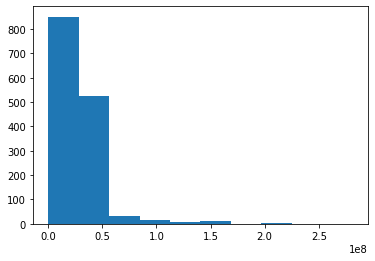

In [142]:
plt.hist(dampings)
print('Uh, oh! I don`t want negative damping^2 values!')

In [143]:
# np.divide(csr_K,mass)
# csr_K.dot(np.linalg.inv(mass))
# k_star = csr_K.sum(axis=0).T
# k_star[0]==np.sum(csr_K[0])

In [144]:
#TODO: verify that all of the spring coefficients are in fact positive in spring_mat,
#  then, if ^they aren't make them at least zero.


h = 10**-7      #time step in seconds 


In [145]:
#advance in time and record data
recording = False
nsteps = 10**2#2*10**5#6*10**1#7*10**3#2
printProgressBar(0, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)
dqdt_old = momentum.copy()
dpdt_old = momentum.copy()
zero_txt = np.zeros((N,N)).astype('float32')
zero_pos = np.array([0.,0.,0.]).astype('float32')
with open(output_file, 'a') as opened_file:
    for step in range(nsteps):
        vertices = np.array(comp.vertices)

        #construct spring-force matrix
        spring_mat = zero_txt.copy()
        calc_spring_mat(spring_mat, vertices, x0_constant_mat, k_constant_mat, VN)

        #compute spring forces
        spring_forces = -np.dot(vertices)
#         csr_K = csr_matrix(spring_mat, dtype=np.float32)
#         spring_forces = -csr_K.dot(vertices)

        #compute pressure forces
        pressure_forces = np.empty_like(spring_forces)
#         get_Fp_mean(vertices, VN, pressure_forces, mesh=comp, P=P)
        get_Fp(vertices, VN, pressure_forces)

        Fnet = spring_forces+pressure_forces
        for vid in vertex_indices_of_caps:
            Fnet[vid] = zero_pos
    
        #integrate in time
        dpdt       = Fnet - np.multiply(dampings,momentum.T).T
        
#         dqdt       = np.divide(2 * momentum.T + dpdt.T , mass).T  # IMR is self adjoint and second order accurate
        dqdt       = np.divide(momentum.T , mass).T 
#         dqdt = dpdt #viscous motion approximation with trivial masses
        
#         comp.vertices += h   * dqdt
#         comp.vertices += h/2 * (dqdt_old + dqdt)
        #         momentum      += h/2 * (dpdt_old + dpdt)
        
        comp.vertices += h/2 * (dqdt_old + dqdt)
        
        dpdt_old = dpdt.copy()
        dqdt_old = dqdt.copy()
        momentum  += h   * dpdt

        tme += h

        if recording:
            #measure desired observables
            volume = comp.volume
            area   = comp.area
            avg_Fs, avg_Fp = mean_magnitudes(spring_forces,pressure_forces)
            my_Q   = get_Q(comp)
            stdout = str((tme, volume, area, avg_Fs, avg_Fp, my_Q)).strip('()')+'\n'
            opened_file.write(stdout)
        printProgressBar(step + 1, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)
beep(5)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
❤


0

In [146]:
volume = comp.volume
area   = comp.area
avg_Fs, avg_Fp = mean_magnitudes(spring_forces,pressure_forces)
my_Q   = get_Q(comp)
print(f"curent time is {tme:.5f} seconds.")
print(f"the volume is {volume:.6f} cm^3.")
print(f"the avg spring force is {avg_Fs:.4f} gcm/s^2.")
print(f"the avg pressure force is {avg_Fp:.0f} gcm/s^2.")
print(f"the avg damping force is {'TODO'} gcm/s^2.")
h

curent time is 0.00001 seconds.
the volume is nan cm^3.
the avg spring force is nan gcm/s^2.
the avg pressure force is nan gcm/s^2.
the avg damping force is TODO gcm/s^2.


1e-07

In [147]:
comp.show()

In [105]:
comp.volume

nan

In [82]:
mesh.volume
# #using my Astar method ~50ms estimated runtime for 1500 mesh points
# def get_Fp(vertices, VN, pressure_forces, mesh, P=5.*1333.):
#     '''returns pressure forces in units of gcm/s^2'''
#     for vid in range(vertices.shape[0]):
#         q = vertices[vid]
#         N1q = vertices[VN[vid]]
#         Fp_magnitude = P*calc_area(q, N1q)
#         pressure_forces[vid] = Fp_magnitude * mesh.vertex_normals[vid]
# def calc_area(q, N1q):
#     '''compute mean area'''
#     q_degree = len(N1q)
#     q_A = 0. #* q
#     for i in range(q_degree - 1, -1, -1):
#         c = N1q[i] -N1q[i-1]
#         d = N1q[i-1] - q
#         q_A += np.linalg.norm(cross_product(N1q[i] - N1q[i-1], N1q[i-1]))
#     q_A /= (2 * q_degree)
#     return q_A

26.27010861352017

In [82]:
# vid = 50
# q = vertices[vid]
# N1q = vertices[VN[vid]]
# retval = calc_area(q, N1q)

In [80]:
np.linalg.norm(retval)

52.14101605135797

In [11]:
for a in range(6 - 1, -1, -1):
    print(a)

5
4
3
2
1
0


# visualizing current force vectors

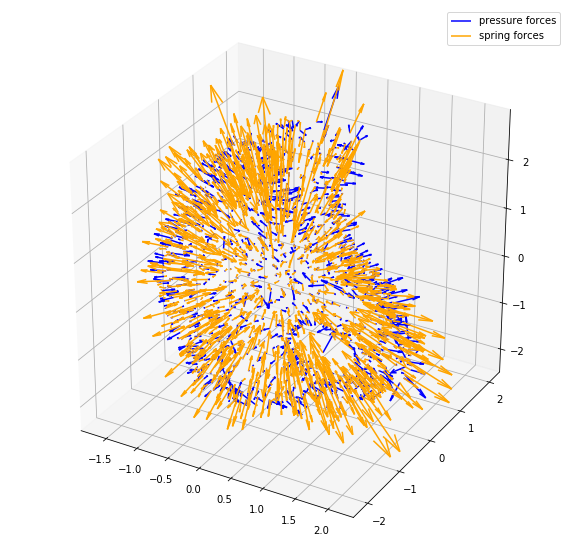

In [87]:
x, y, z = comp.vertices.T
u, v, w    = pressure_forces.T
us, vs, ws = spring_forces.T

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.quiver(x, y, z, u, v, w, length=.001, normalize=False, color='blue', label='pressure forces')
ax.quiver(x, y, z, us, vs, ws, length=1000, normalize=False, color='orange', label='spring forces')
ax.legend()
plt.show()



# parse tom irving's python code

In [258]:
import tompy, ode_plots, Newmark, generalized_eigen

def Newmark_free(M,C,K,VI,DI,dt,NT,ndof):
    """
    input

    M = mass matrix
    C = damping matrix
    K = stiffness matrix

    VI = initial velocity
    DI = initial displacement

      dt = time step
      NT = number of time points
    ndof = number of degrees of freedom

    output

      U = displacement
     Ud = velocity
    Udd = acceleration

    """

def Newmark_force(M,C,K,FFI,force_dof,VI,DI,dt,NT,ndof):
    """
    input

    M = mass matrix
    C = damping matrix
    K = stiffness matrix

    FFI = interpolated force matrix
    force_dof = connects forces with dofs

    VI = initial velocity
    DI = initial displacement

      dt = time step
      NT = number of time points
    ndof = number of degrees of freedom

    output

      U = displacement
     Ud = velocity
    Udd = acceleration

    """

def Newmark_force_modal(M,C,K,FFI,force_dof,VI,DI,dt,NT,ndof,MS):
    """
    input

    M = mass matrix
    C = damping matrix
    K = stiffness matrix

    FFI = interpolated force matrix
    force_dof = connects forces with dofs

    VI = initial velocity
    DI = initial displacement

      dt = time step
      NT = number of time points
    ndof = number of degrees of freedom

    MS = mode shapes

    output

      U = displacement
     Ud = velocity
    Udd = acceleration

    """

# add damping to my ball and spring model

# TODO: Test driven redevelopment of ball and spring model.



In [148]:
# Question: can the ball-and-spring model satisfy the same tests as the corotated linear model?  

# TODO: compute the net force vector acting on each side of the deformed triangle
# TODO: visualize the nodal spring forces for a simple highly symmetric case
# TODO: visualize the nodal spring & pressure forces for that same case

# TODO: model the nodal forces on one vertex with a fixed 1-ring (highly-symmetric)
# TODO: time evolve ^that by FEI.  Did you use damping?
# TODO: model the nodal forces on one vertex and its 1-ring with a fixed 2-ring (highly-symmetric)
# TODO: time evolve ^that by FEI.  Did you use damping?

# TODO: can I get this to work on the full RA?
# TODO: can the ball-and-spring model satisfy the same tests?  